In [62]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
import hopsworks
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [74]:
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/224406
Connected. Call `.close()` to terminate connection gracefully.


In [75]:
wine_df = pd.read_csv("https://raw.githubusercontent.com/ID2223KTH/id2223kth.github.io/master/assignments/lab1/wine.csv")

wine_df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [65]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [77]:
wine_df = wine_df.drop_duplicates()
wine_df['quality'].value_counts()


quality
6    2327
5    1755
7     857
4     206
8     149
3      30
9       5
Name: count, dtype: int64

Most value are between 5-7 in quality

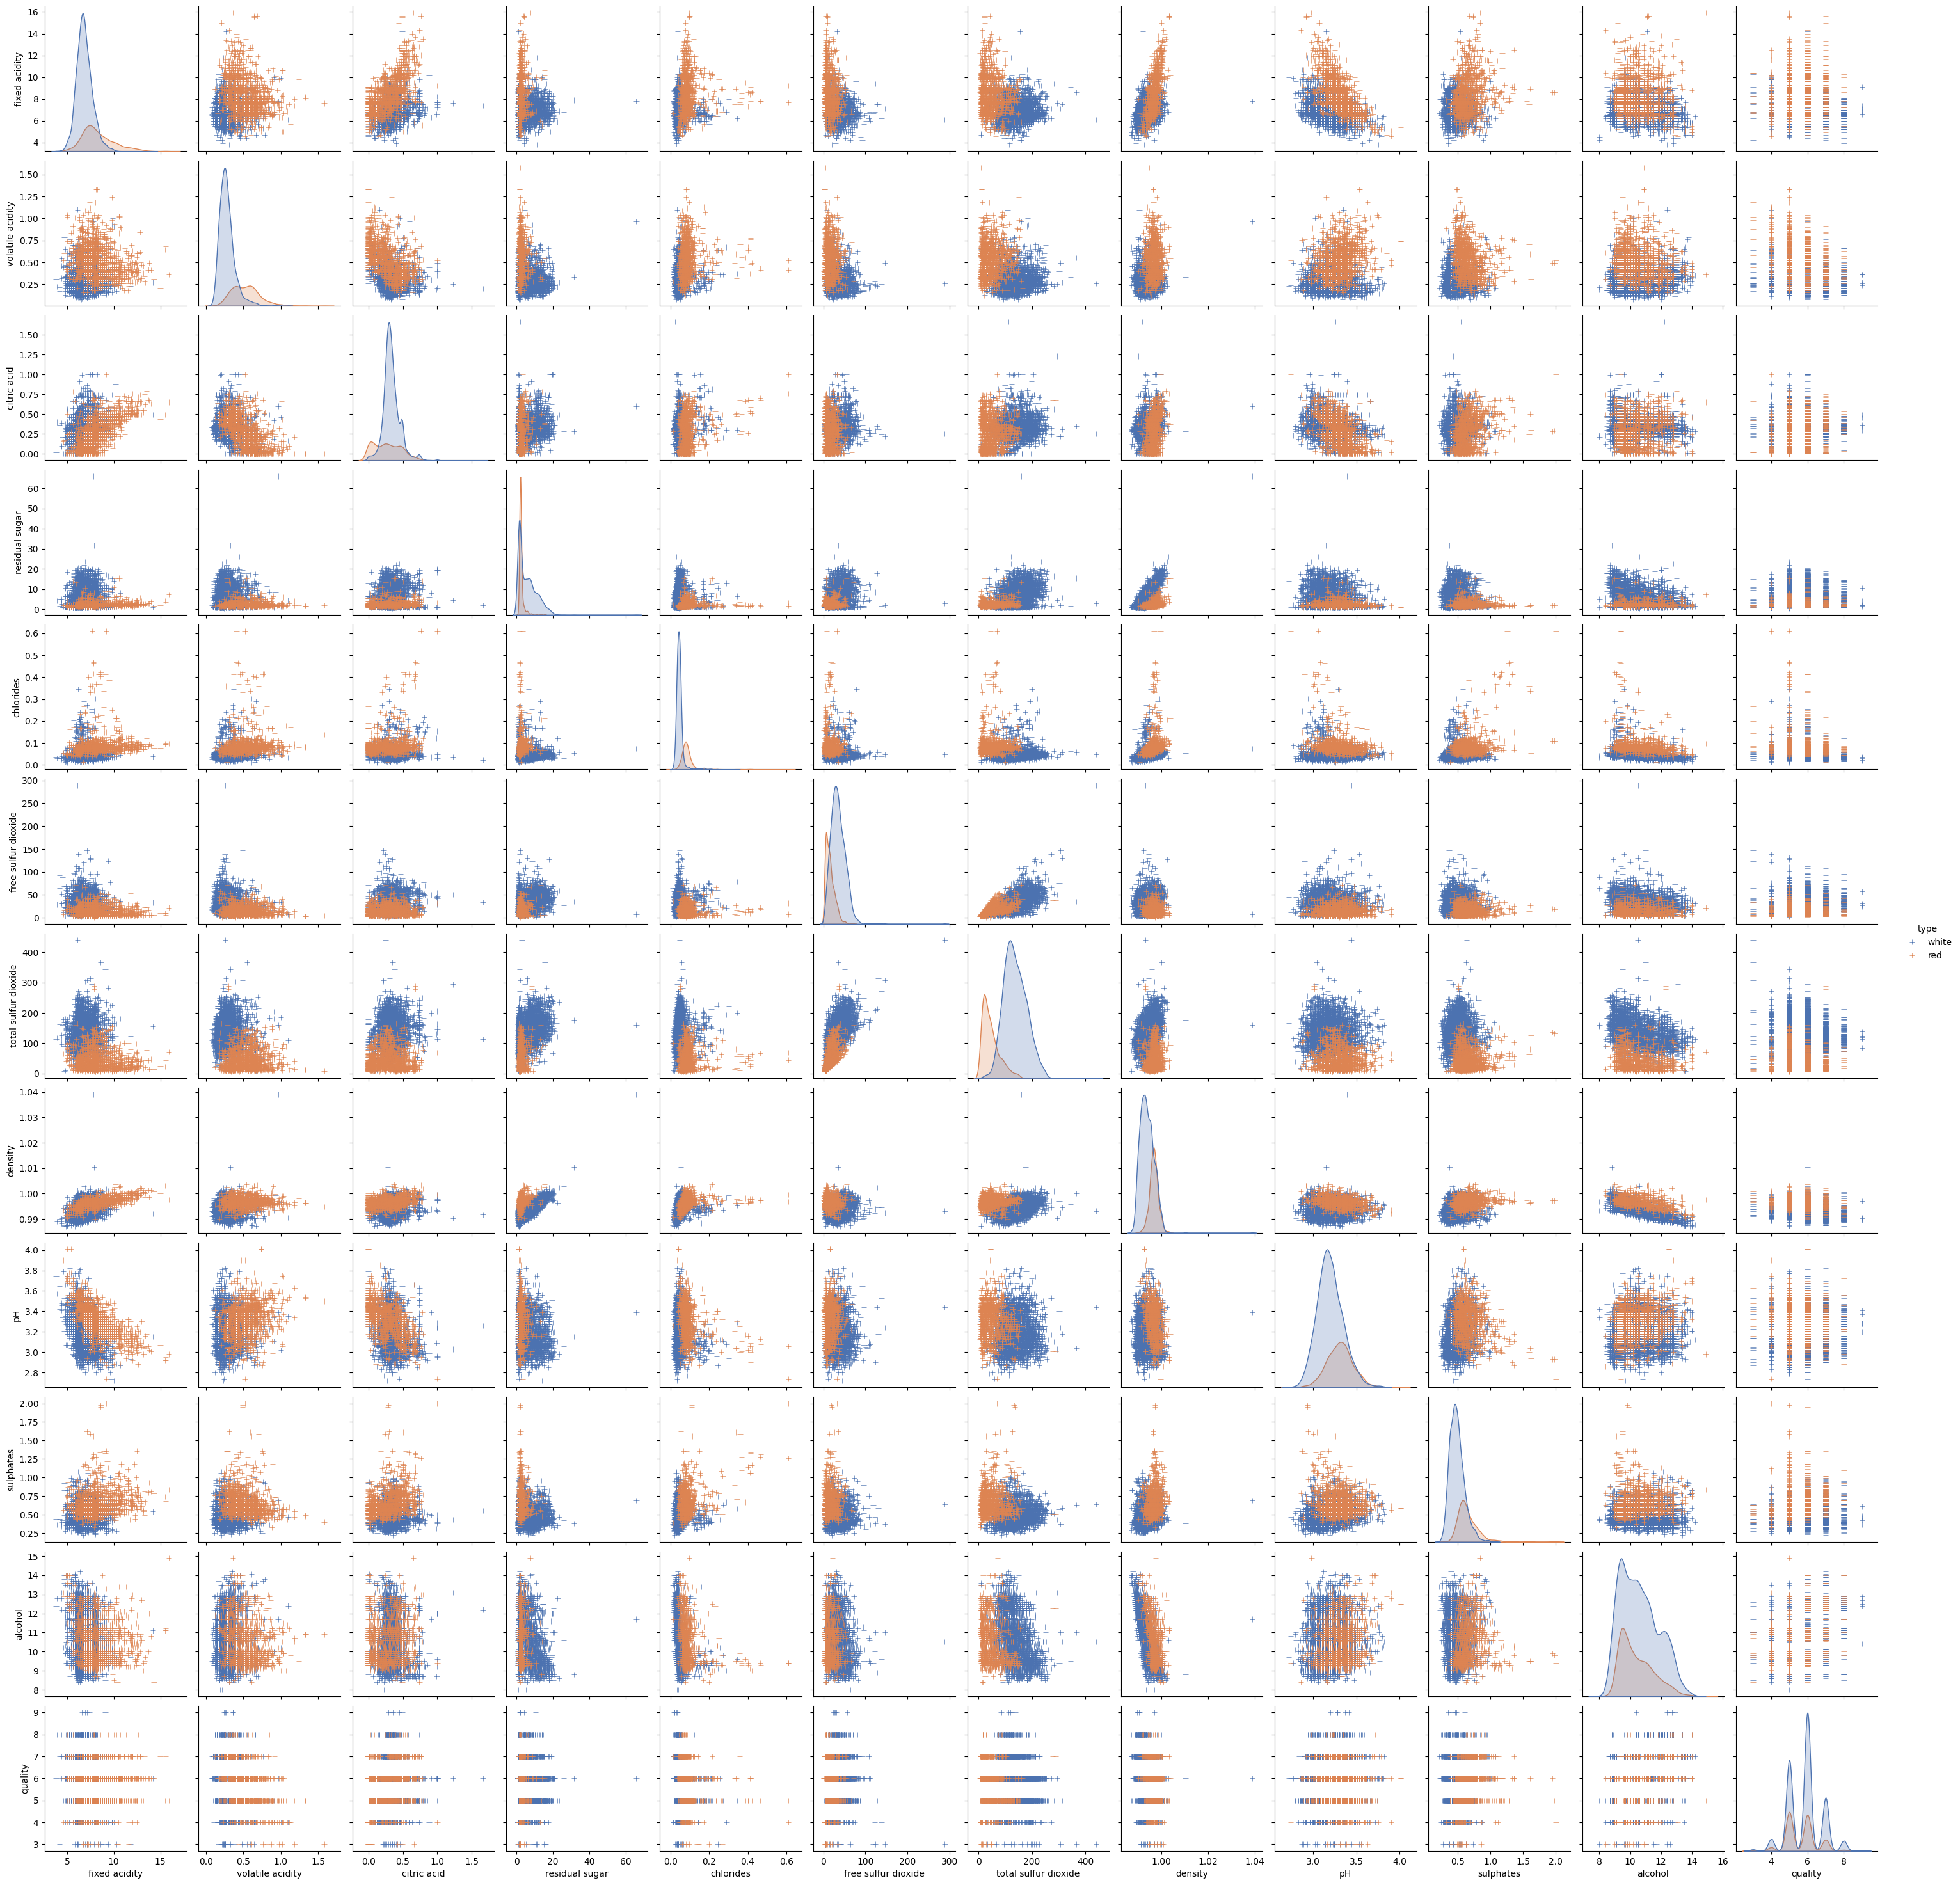

In [67]:
g = sns.pairplot(wine_df, hue='type', markers='+', palette="deep")
plt.show()

Relations between two different features can differ depending on if the wine is red or white. One example is volatie acidity and total sulfur dioxide.

In [78]:
#Turn categorical feature into numerical, only for red/white
wine_df = pd.get_dummies(wine_df, columns=['type'], prefix='type')

<Axes: >

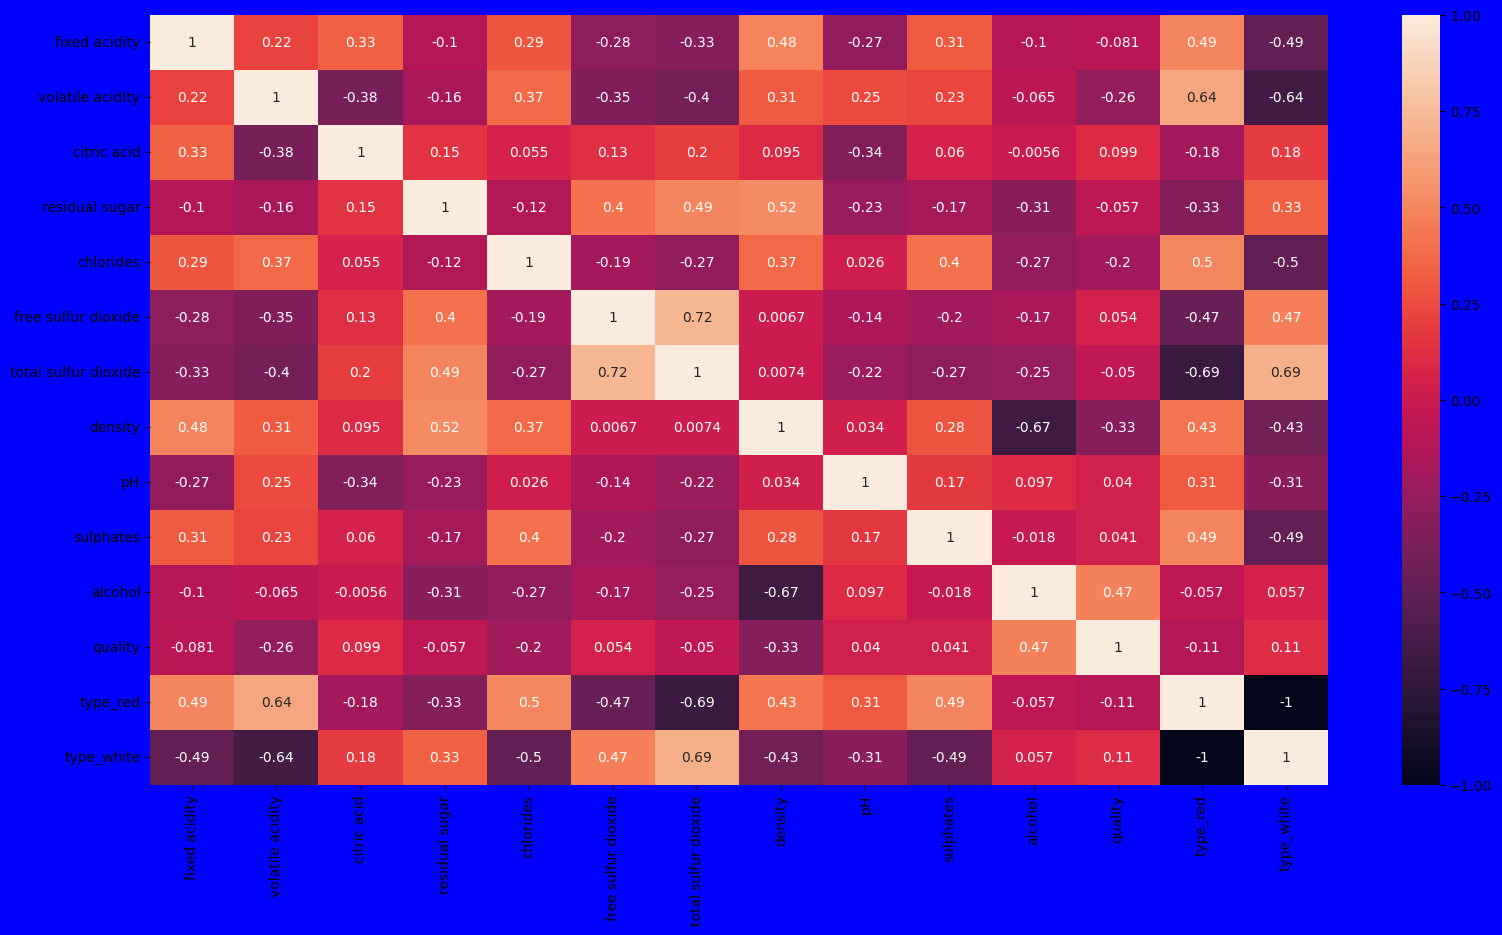

In [69]:
# ploting heatmap
plt.figure(figsize=[19,10],facecolor='blue')
sns.heatmap(wine_df.corr(),annot=True)


Free sulfur dioxide and total sulfur dioxide are highly correlated (pretty intuitive). Therefore we remove free, and instead add a ratio between them as a new feature.

It seems that the type of wine is also highly correlated with some features. Red wine has a positive correlation with volatile acidity and negative with total sulfur dioxide, and white wine is vice versa.

In [79]:
#Total sulfur dioxide includes free - there is a correlation, remove free sulfur and add column free/total
wine_df['sulfur dioxide ratio'] = wine_df['free sulfur dioxide'] / wine_df['total sulfur dioxide']
wine_df = wine_df.drop("free sulfur dioxide", axis=1)

In [80]:
#Replace null-values
columns_to_fill = wine_df.columns

for col in columns_to_fill:
    if wine_df[col].dtype == float:
        wine_df[col].fillna(wine_df[col].mean(), inplace=True)
    else:
        mode_value = wine_df[col].mode().iloc[0]
        wine_df[col].fillna(mode_value, inplace=True)


In [23]:
wine_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,5329.0,7.216573,1.317955,3.80000,6.4000,7.00000,7.70000,15.90000
volatile acidity,5329.0,0.344123,0.168102,0.08000,0.2300,0.30000,0.41000,1.58000
citric acid,5329.0,0.318738,0.147075,0.00000,0.2400,0.31000,0.40000,1.66000
residual sugar,5329.0,5.053839,4.503160,0.60000,1.8000,2.70000,7.50000,65.80000
chlorides,5329.0,0.056668,0.036838,0.00900,0.0380,0.04700,0.06600,0.61100
free sulfur dioxide,5329.0,30.060143,17.815588,1.00000,16.0000,28.00000,41.00000,289.00000
total sulfur dioxide,5329.0,114.189341,56.781422,6.00000,75.0000,116.00000,154.00000,440.00000
density,5329.0,0.994536,0.002966,0.98711,0.9922,0.99464,0.99677,1.03898
pH,5329.0,3.224434,0.160140,2.72000,3.1100,3.21000,3.33000,4.01000
sulphates,5329.0,0.533268,0.149668,0.22000,0.4300,0.51000,0.60000,2.00000


Remove density column due to very small std. There are other features with low std or with a lot of outliers which we would like to account for and experiment with if we had more time.

In [81]:
wine_df = wine_df.drop("density", axis=1)

In [82]:
#Rewrite column names so they do not contain spaces
wine_df.columns = wine_df.columns.str.replace(' ', '_')

In [35]:
wine_df.info()

quality_stats = wine_df.groupby('quality').agg({'fixed_acidity': ['min', 'max'],
                                           'volatile_acidity': ['min', 'max'],
                                           'citric_acid': ['min', 'max'],
                                           'residual_sugar': ['min', 'max'],
                                           'chlorides': ['min', 'max'],
                                           'total_sulfur_dioxide': ['min', 'max'],
                                           'pH': ['min', 'max'],
                                           'sulphates': ['min', 'max'],
                                           'sulfur_dioxide_ratio': ['min', 'max'],
                                           'alcohol': ['min', 'max']})

# Display the result
print(quality_stats)

<class 'pandas.core.frame.DataFrame'>
Index: 5329 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         5329 non-null   float64
 1   volatile_acidity      5329 non-null   float64
 2   citric_acid           5329 non-null   float64
 3   residual_sugar        5329 non-null   float64
 4   chlorides             5329 non-null   float64
 5   total_sulfur_dioxide  5329 non-null   float64
 6   pH                    5329 non-null   float64
 7   sulphates             5329 non-null   float64
 8   alcohol               5329 non-null   float64
 9   quality               5329 non-null   int64  
 10  type_red              5329 non-null   bool   
 11  type_white            5329 non-null   bool   
 12  sulfur_dioxide_ratio  5329 non-null   float64
dtypes: bool(2), float64(10), int64(1)
memory usage: 510.0 KB
        fixed_acidity       volatile_acidity        citric_acid        

The following code was used to get max/min values for the wine-feature-pipeline-daily

In [39]:
quality_intervals = wine_df.groupby('quality').apply(lambda group: [(group[col].min(), group[col].max()) for col in group.columns[0:]])

all_intervals = quality_intervals.tolist()

print(all_intervals)


[[(4.2, 11.8), (0.17, 1.58), (0.0, 0.66), (0.7, 16.2), (0.022, 0.267), (9.0, 440.0), (2.87, 3.63), (0.28, 0.86), (8.0, 12.6), (3, 3), (False, True), (False, True), (0.045871559633027525, 0.7083333333333334)], [(4.6, 12.5), (0.11, 1.13), (0.0, 1.0), (0.7, 17.55), (0.013, 0.61), (7.0, 272.0), (2.74, 3.9), (0.25, 2.0), (8.4, 13.5), (4, 4), (False, True), (False, True), (0.033707865168539325, 0.7083333333333334)], [(4.5, 15.9), (0.1, 1.33), (0.0, 1.0), (0.6, 23.5), (0.009, 0.611), (6.0, 344.0), (2.79, 3.79), (0.27, 1.98), (8.0, 14.9), (5, 5), (False, True), (False, True), (0.023622047244094488, 0.782608695652174)], [(3.8, 14.3), (0.08, 1.04), (0.0, 1.66), (0.7, 65.8), (0.015, 0.415), (6.0, 294.0), (2.72, 4.01), (0.23, 1.95), (8.4, 14.0), (6, 6), (False, True), (False, True), (0.022727272727272728, 0.8571428571428571)], [(4.2, 15.6), (0.08, 0.915), (0.0, 0.76), (0.9, 19.25), (0.012, 0.358), (7.0, 289.0), (2.84, 3.82), (0.22, 1.36), (8.6, 14.2), (7, 7), (False, True), (False, True), (0.05, 0

In [83]:
#Rename pH to ph
wine_df = wine_df.rename(columns={'pH': 'ph'})

In [84]:
wine_fg = fs.get_or_create_feature_group(
    name="winedataset",
    version=1,
    primary_key=["fixed_acidity", "volatile_acidity", "citric_acid",
                  "chlorides","total_sulfur_dioxide", "sulphates",
                  "alcohol", "sulfur_dioxide_ratio"], 
    description="Wine dataset without ph and residual sugar")

wine_fg.insert(wine_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/224406/fs/224325/fg/239990


Uploading Dataframe: 100.00% |██████████| Rows 5329/5329 | Elapsed Time: 00:08 | Remaining Time: 00:00


Launching job: winedataset_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/224406/jobs/named/winedataset_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f91a9337430>, None)